## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import math
import itertools
import matplotlib.pyplot as plt
#from lane_line import Line

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
def plot_images(images, label=None, n_cols=5, cmap=None):
    """
    plot images in n_cols columns
    :param images 
    :param label image labels
    :param n_cols number of columns
    """
    n_rows = math.ceil(len(images)/n_cols)
 
    plt.figure(figsize=(20, n_rows*10/n_cols))   
    for i,image in enumerate(images):
        #image = image.squeeze()
        plt.subplot(n_rows, n_cols, i+1)  
        if label != None:
            plt.title("Output " + str(label[i]))
        plt.imshow(image, aspect='equal', cmap=cmap)
    plt.show()

def plot_compare_images(left_images, right_images, cmap=None):
    mixed_images = list(itertools.chain.from_iterable(zip(left_images,right_images)))
    plot_images(mixed_images, n_cols=2, cmap=cmap)
    
def plot_histogram(labels, n_labels):
    """
    Exploration of the label distribution
    """
    plt.hist(labels, n_labels)
    plt.xlabel('Labels')
    plt.ylabel('Label Count')
    plt.title('Histogram')
    plt.show()

In [130]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
cal_files = glob.glob('./camera_cal/calibration*.jpg')
# Make a list of test images
test_files = glob.glob('./test_images/*.jpg')
# Make a list of challenge images
#test_files = glob.glob('./challenge_images/*.jpg')

corner_images = []

# Step through the list and search for chessboard corners
for fname in cal_files:
    img = plt.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_images.append(img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## And so on and so forth...

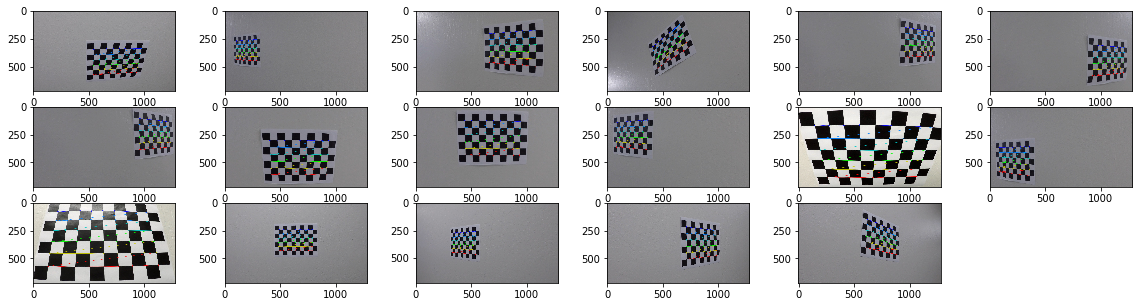

In [4]:
plot_images(corner_images, n_cols=6)

In [131]:
#Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

cal_images = []
cal_distorted_images = []
for fname in cal_files:
    img = plt.imread(fname)
    cal_distorted_images.append(img)
    cal_images.append(cv2.undistort(img, mtx, dist, None, mtx))

test_images = []
for fname in test_files:
    img = plt.imread(fname)
    test_images.append(cv2.undistort(img, mtx, dist, None, mtx))

#### Example of distorted and undistorted image

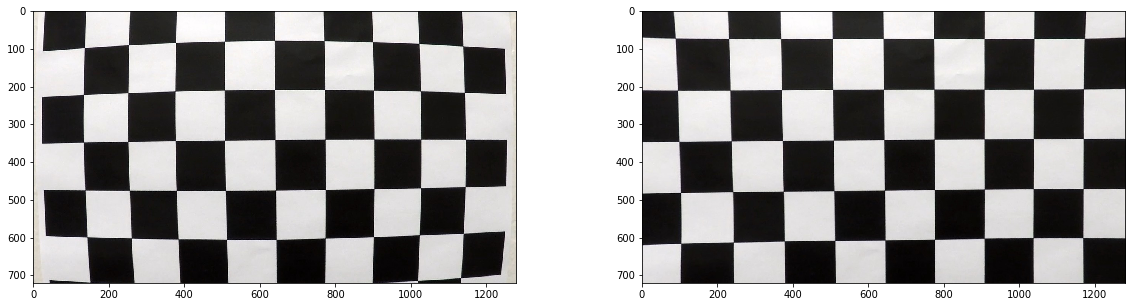

In [6]:
plot_compare_images(cal_distorted_images[0:1], cal_images[0:1])

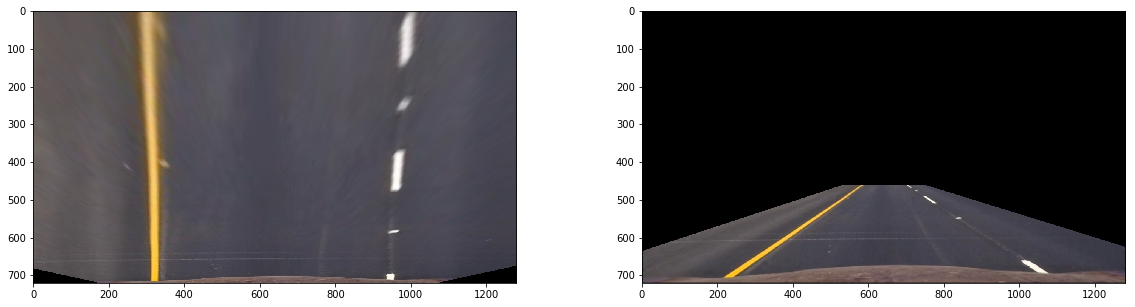

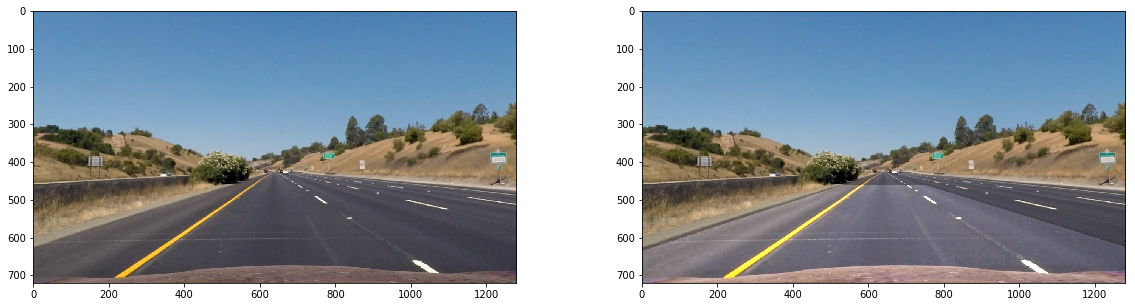

In [132]:
def get_perspective_matrices(img):
    '''
    '''
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # Return the resulting matrix and inverse
    return M, Minv

def warp(img, img_size, M):
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(img, M, img_size)

img_size = (test_images[0].shape[1], test_images[0].shape[0])
M, Minv = get_perspective_matrices(test_images[0])
warped_img = warp(test_images[0], img_size, M)
unwarped_img = warp(warped_img, img_size, Minv)
plot_compare_images([warped_img], [unwarped_img])
result = cv2.addWeighted(test_images[0], 1, unwarped_img, 0.5, 0)
plot_compare_images([test_images[0]], [result])


In [136]:
test_warped = [warp(img, img_size, M) for img in test_images]

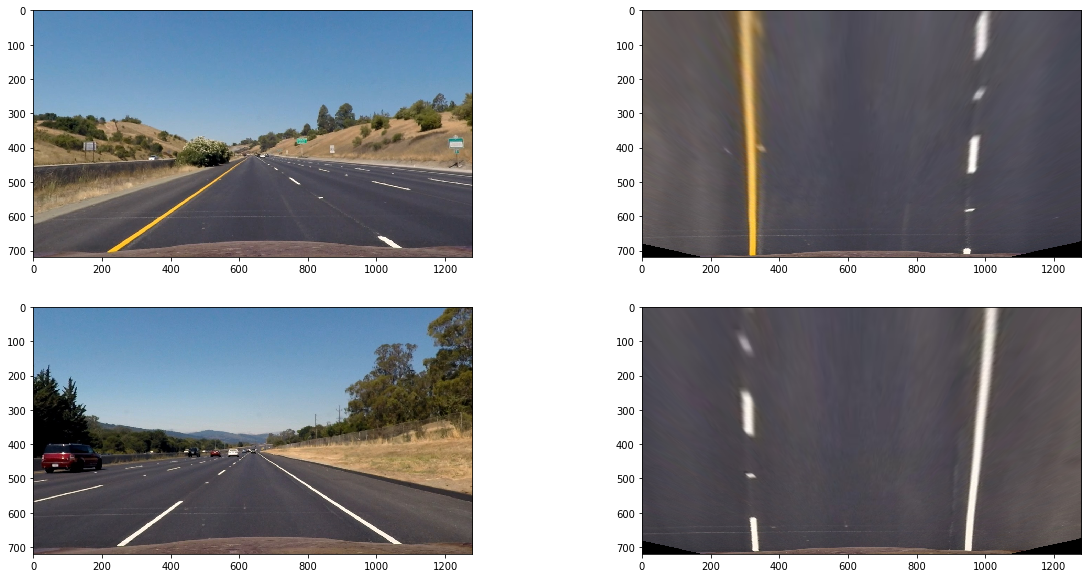

In [137]:
plot_compare_images(test_images[0:2], test_warped[0:2])

In [164]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def reject_outliers(data, m=2):
    """
    Reject outliers in data which are more than
    m * StandardDeviations away from the median
    """    
    return data[abs(data - np.median(data)) < m * np.std(data)] 

def select_color_code(func):
    def wrapper(img, code, *args, **kwargs):
        if code != None:
            img = cv2.cvtColor(img, code)
        func(img)
    return wrapper

def select_channel(img, channel=0):
    return None

                    
def channel_select(img, thresh=(0, 255), channel=2, code=cv2.COLOR_RGB2HLS):
    '''
    Function that thresholds the desired channel of selected color space 
    :param img: RGB input image
    :param thresh: threshold tupel from 0..255. thresh[0] < pixel <= thresh[1] are included
    :param channel: select color channel (e.g. H=0, L=1, S=2)
    :param code: 
    '''
    # use other color space than the original one
    if code != None:
        img = cv2.cvtColor(img, code)
    # select channel
    channel = img[:,:,channel]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1  
    return binary_output


def abs_sobel(sobelx, sobely):
    '''
    Take the absolute values of the sobel gradient and add/scale them    
    '''
    abs_sobel = np.absolute(sobelx) + np.absolute(sobely)
    # Rescale back to 8 bit integer
    return np.uint8(255*abs_sobel/np.max(abs_sobel))   

def mag_sobel(sobelx, sobely):
    '''
    Take the magnitude value of the sobel gradients and scale them   
    '''
    magn = np.sqrt(sobelx**2 + sobely**2)
    # Rescale back to 8 bit integer
    return np.uint8(255 * magn/np.max(magn))

def dir_sobel(sobelx, sobely):
    '''
    Use arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    '''
    return np.arctan2(np.absolute(sobelx), np.absolute(sobely))    

def sobel_thresh(img, thresh=(0,255), sobel_kernel=9, orient='xy', func=abs_sobel):
    '''
    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print(gray[:,:,0].shape)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if orient == 'x':
        sobely = 0
    elif orient == 'y':
        sobelx = 0
    # apply function on sobel values, e.g. magnitude, direction
    scaled_sobel = func(sobelx, sobely)   
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output = cv2.adaptiveThreshold(scaled_sobel,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    # Return the result
    return binary_output


def stack_binaries(first, second):
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    return np.dstack(( first, second, np.zeros_like(first)))

def combine_binaries(first, second):    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(first)
    combined_binary[(first == 1) | (second == 1)] = 1
    return combined_binary

def _binaries(first, second):    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(first)
    combined_binary[(first == 1) & (second == 1)] = 1
    return combined_binary

In [165]:
h_binaries = [channel_select(img, thresh=(90,225), channel=0) for img in test_images]
l_binaries = [channel_select(img, thresh=(200,225), channel=1) for img in test_images]
s_binaries = [channel_select(img, thresh=(90,225), channel=2) for img in test_images]
r_binaries = [channel_select(img, thresh=(225,255), channel=0, code=None) for img in test_images]

mag_binaries = [sobel_thresh(img, thresh=(50,100),func=mag_sobel) for img in test_images]
#dir_test_images = [sobel_thresh(img, thresh=(0.7, 1.2),func=dir_sobel) for img in test_images]
abs_binaries = [sobel_thresh(img, thresh=(15, 255),func=abs_sobel, orient='x', sobel_kernel=3) for img in test_images]
r_abs_stack_binaries = [stack_binaries(r, abs) for r,abs in zip(r_binaries, abs_binaries)]
r_abs_binaries = [combine_binaries(r, abs) for r,abs in zip(r_binaries, abs_binaries)]

In [178]:
h_warped = [channel_select(img, thresh=(90,225), channel=0) for img in test_warped]
l_warped = [channel_select(img, thresh=(200,255), channel=1) for img in test_warped]
s_warped = [channel_select(img, thresh=(90,225), channel=2) for img in test_warped]
r_warped = [channel_select(img, thresh=(222,255), channel=0, code=None) for img in test_warped]

mag_warped = [sobel_thresh(img, thresh=(100,255),func=mag_sobel, sobel_kernel=9) for img in test_warped]
dir_warped = [sobel_thresh(img, thresh=(0.7, 1.3),func=dir_sobel, sobel_kernel=15) for img in test_warped]
abs_warped = [sobel_thresh(img, thresh=(55, 255),func=abs_sobel, orient='x', sobel_kernel=15) for img in test_warped]
r_s_warped = [combine_binaries(r, s) for r,s in zip(r_warped, s_warped)]
abs_r_s_warped = [combine_binaries(r, s) for r,s in zip(r_s_warped, abs_warped)]
r_s_l_warped = [combine_binaries(r, l) for r,l in zip(r_s_warped, l_warped)]

abs_dir_warped = [_binaries(r, l) for r,l in zip(abs_warped, dir_warped)]

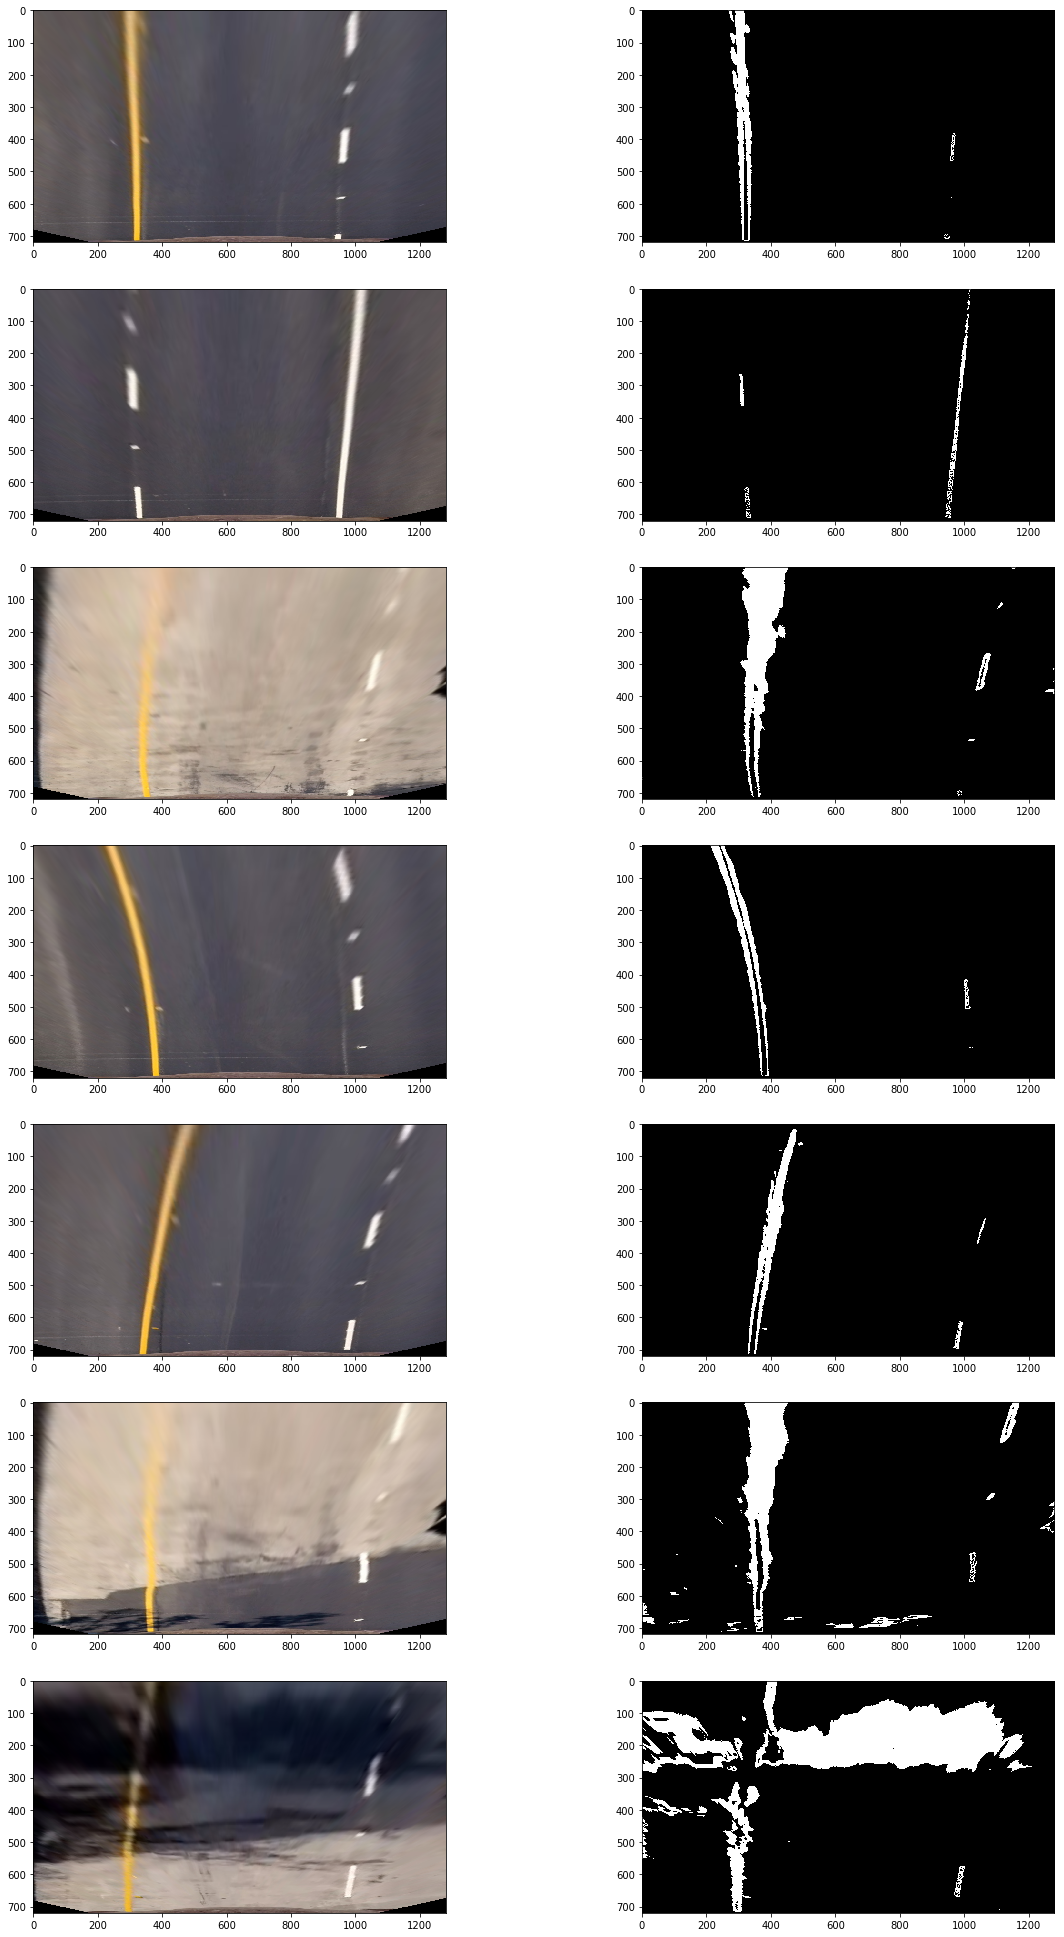

In [222]:
plot_compare_images(test_warped[0:-1], s_warped [0:-1], cmap='gray')

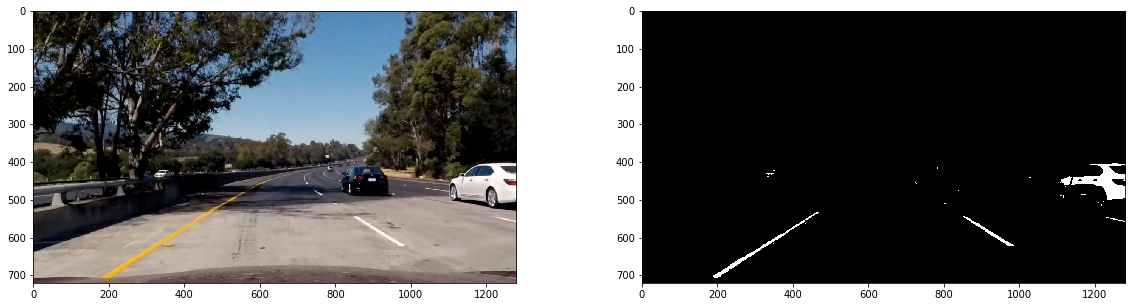

In [176]:
plot_compare_images(test_images[-2:-1], r_binaries[-2:-1], cmap='gray')

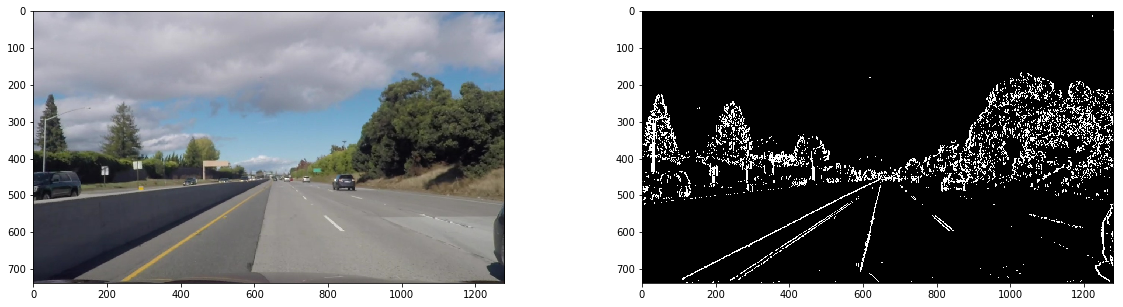

In [15]:
plot_compare_images(test_images[-2:-1], abs_binaries[-2:-1], cmap='gray')

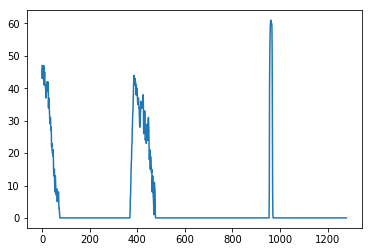

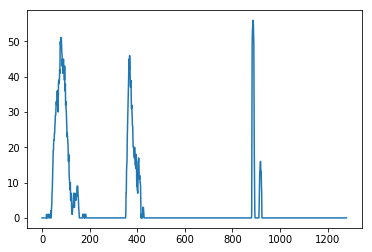

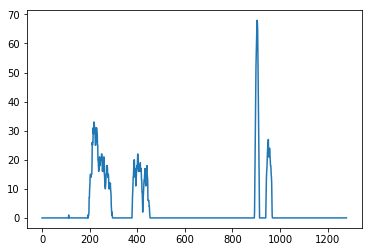

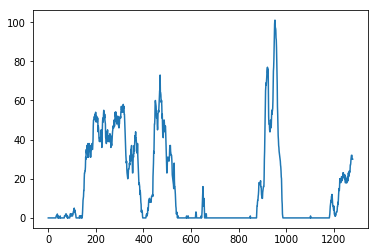

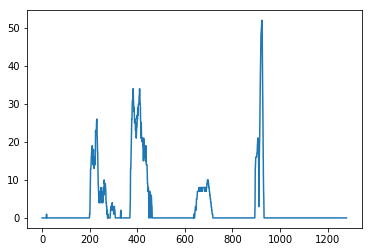

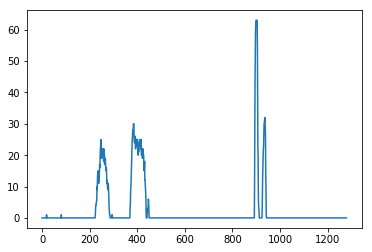

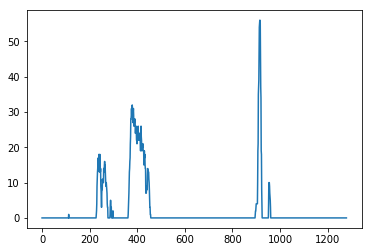

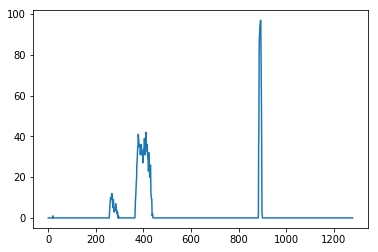

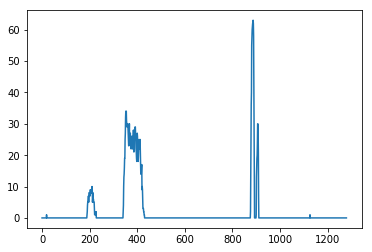

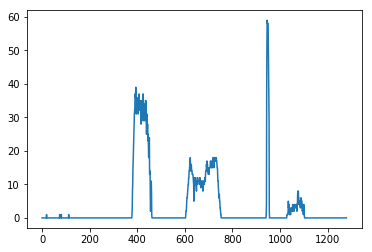

In [67]:
histograms = [np.sum(img[int(img.shape[0]/2):,:], axis=0) for img in r_s_l_warped]
for h in histograms:
    plt.plot(h)
    plt.show()

In [68]:
def binary2image(binary_image):
    return np.dstack((binary_image, binary_image, binary_image))*255

def nonzero_x_y(image):
    """
    Identify the x and y positions of all nonzero pixels in the image
    """ 
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

In [69]:
def get_lane_base(binary_warped):
    """
    find the basepoints, midpoint, left and right lane base
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

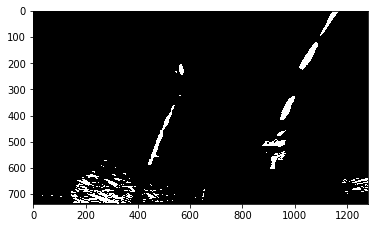

Number of data points 5485
[  1.82646789e-04  -4.79044847e-01   6.70932635e+02]


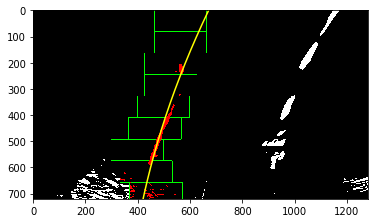

Number of data points 9936
[  4.90062098e-04  -6.95262428e-01   1.16030011e+03]


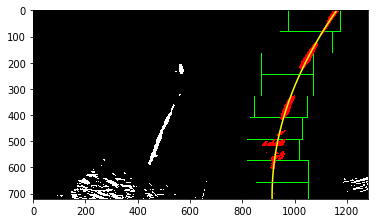

[  6.35359446e-05  -5.07488729e-01   6.83641915e+02]
[  1.33160640e-04  -2.46713988e-01   9.86558100e+02]


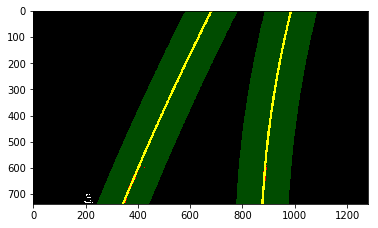

In [92]:
binary_warped = r_s_l_warped[3]
_, leftx_base, rightx_base = get_lane_base(binary_warped)
out_img = binary2image(binary_warped)
plt.imshow(out_img)
plt.show()

%run lane_line.py
left_line = Line()
right_line = Line()
left_line.fit_sliding_window(binary_warped, leftx_base, plot=True)
right_line.fit_sliding_window(binary_warped, rightx_base, plot=True)

binary_warped = r_s_warped[-2]
out_img = binary2image(binary_warped)

left_line.fit_previous(binary_warped)
right_line.fit_previous(binary_warped)
out_img = left_line.draw_poly(out_img)
out_img = right_line.draw_poly(out_img)
right_line.draw_fit(out_img)

plt.imshow(out_img)
plt.show()

Number of data points 25392
[ -2.58850791e-05   5.75563792e-02   2.97094805e+02]
1.66449117136
Number of data points 2819
[ -4.85525066e-06  -6.74383733e-02   9.91533584e+02]
-1.5885443521


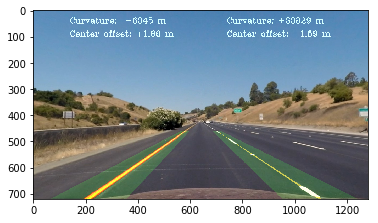

In [280]:
%run lane_line.py
left_lane = Line()
right_lane = Line()

def process_image(img):
    """
    Processing image pipeline
    """       
    img_size = (img.shape[1], img.shape[0])
    # 1. undistort image
    img= cv2.undistort(img, mtx, dist, None, mtx)
    #img = gaussian_blur(img, kernel=5)
    # 2. warp image
    M, Minv = get_perspective_matrices(img)
    warped  = warp(img, img_size, M)
    # 3. filter lanes with color and sobel tresholds
    h_warped = channel_select(warped, thresh=(80,2555), channel=0)
    r_warped = channel_select(warped, thresh=(222,255), channel=0, code=None) 
    l_warped = channel_select(warped, thresh=(200,255), channel=1) 
    s_warped = channel_select(warped, thresh=(90,225), channel=2)
    #abs_warped = sobel_thresh(warped, thresh=(55, 255),func=abs_sobel, orient='x', sobel_kernel=9) 
    binary_warped = combine_binaries(r_warped, s_warped) 
    #binary_warped = combine_binaries(binary_warped, l_warped) 
    # 4. detect lanes and fit second order polynom
    _, leftx_base, rightx_base = get_lane_base(binary_warped)
    if left_lane.detected:
        left_lane.fit_previous(binary_warped)  
        print("Detected == True")
    else:
        left_lane.fit_sliding_window(binary_warped, leftx_base)
    if right_lane.detected:
        right_lane.fit_previous(binary_warped)
    else:
        right_lane.fit_sliding_window(binary_warped, rightx_base)
    # draw lanes and print curvature
    out_img = binary2image(binary_warped)
    out_img = left_lane.draw_all(out_img)
    out_img = right_lane.draw_all(out_img)
    unwarped = warp(out_img, img_size, Minv)
    unwarped = left_lane.draw_curvature(unwarped, pos=(140, 50))
    unwarped = left_lane.draw_center_offset(unwarped, pos=(140, 100))
    unwarped = right_lane.draw_curvature(unwarped, pos=(740, 50))
    unwarped = right_lane.draw_center_offset(unwarped, pos=(740, 100))

    result = cv2.addWeighted(img, 1, unwarped, 0.5, 0)
    return result

#plt.figure(figsize=(16,8))
plt.imshow(process_image(test_images[0]))
plt.show()
    

In [270]:
left_lane = Line()
right_lane = Line()
lane_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False).subclip(22,29)
#clip1 = VideoFileClip("challenge_video.mp4", audio=False)
#clip1.save_frame("frame1.png")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(lane_output, audio=False)

Number of data points 43743
[ -1.08955260e-04   1.34550337e-01   2.83855611e+02]
1.66884967669
Number of data points 5351
[ -3.99164835e-05  -1.18113444e-01   1.07274385e+03]
-1.7294065023
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                  | 0/176 [00:00<?, ?it/s]

[ -1.15048890e-04   1.37653506e-01   2.83618623e+02]
1.67495984567
Detected == True
[ -3.99164835e-05  -1.18113444e-01   1.07274385e+03]
-1.7294065023


  1%|▍                                                                         | 1/176 [00:00<00:34,  5.13it/s]

[  4.80853138e-06   5.87771005e-02   2.91004616e+02]
1.60817236332
Detected == True
[ -2.43648158e-05  -1.40537361e-01   1.08369078e+03]
-1.74454345265


  1%|▊                                                                         | 2/176 [00:00<00:32,  5.42it/s]

[ -1.25715312e-05   7.06456976e-02   2.90308317e+02]
1.61423820626
Detected == True
[ -1.03897624e-05  -1.52892837e-01   1.08667575e+03]
-1.75155199848


  2%|█▎                                                                        | 3/176 [00:00<00:30,  5.64it/s]

[ -2.44852149e-05   8.62989743e-02   2.84006401e+02]
1.62061341551
Detected == True
[ -7.24567213e-07  -1.62951941e-01   1.09011551e+03]
-1.75791487472


  2%|█▋                                                                        | 4/176 [00:00<00:29,  5.81it/s]

[ -4.15365633e-05   9.31793982e-02   2.87018862e+02]
1.62513479258
Detected == True
[  1.76975336e-05  -1.67866507e-01   1.08678592e+03]
-1.77197670953


  3%|██                                                                        | 5/176 [00:00<00:29,  5.78it/s]

[ -7.23110245e-05   1.08292713e-01   2.91427853e+02]
1.62848452067
Detected == True
[  3.21264404e-05  -1.63461618e-01   1.07740002e+03]
-1.77853309254


  3%|██▌                                                                       | 6/176 [00:01<00:28,  5.86it/s]

[ -7.50877758e-05   1.07458266e-01   2.93964445e+02]
1.62583556726
Detected == True
[  2.63179301e-05  -1.55154607e-01   1.07264803e+03]
-1.76911385448


  4%|██▉                                                                       | 7/176 [00:01<00:27,  6.08it/s]

[ -8.46958321e-05   1.23167038e-01   2.85231043e+02]
1.63855186216
Detected == True
[  5.14556347e-05  -1.80616731e-01   1.08125579e+03]
-1.78653397957


  5%|███▎                                                                      | 8/176 [00:01<00:27,  6.02it/s]

[ -7.17793655e-05   1.35388090e-01   2.64731289e+02]
1.66516812126
Detected == True
[  3.55038551e-05  -2.05138361e-01   1.11205478e+03]
-1.81254759072


  5%|███▊                                                                      | 9/176 [00:01<00:27,  6.09it/s]

[ -2.40547415e-05   1.49742807e-01   2.26846357e+02]
1.68045504806
Detected == True
[  4.11508969e-05  -2.70359434e-01   1.16701266e+03]
-1.87060176202


  6%|████▏                                                                    | 10/176 [00:01<00:27,  6.14it/s]

[ -2.70241076e-05   1.62451511e-01   2.14660002e+02]
1.70468393503
Detected == True
[  4.50274954e-05  -2.96652339e-01   1.18348803e+03]
-1.86835443124


  6%|████▌                                                                    | 11/176 [00:01<00:26,  6.30it/s]

[ -6.26910265e-05   2.08624494e-01   1.95505189e+02]
1.72791382319
Detected == True
[  3.15075162e-05  -3.03800851e-01   1.20000415e+03]
-1.89154302032


  7%|████▉                                                                    | 12/176 [00:01<00:26,  6.22it/s]

[ -2.01755444e-05   1.25733998e-01   2.38487221e+02]
1.69956859041
Detected == True
[  3.35595292e-05  -2.46151723e-01   1.15110876e+03]
-1.85779454216


  7%|█████▍                                                                   | 13/176 [00:02<00:26,  6.23it/s]

[ -2.58680731e-05   8.50320723e-02   2.73254010e+02]
1.68604091981
Detected == True
[ -1.40891248e-06  -1.53107397e-01   1.09590150e+03]
-1.82404148845


  8%|█████▊                                                                   | 14/176 [00:02<00:25,  6.24it/s]

[ -2.91168309e-05   7.20053847e-02   2.87594450e+02]
1.66862570505
Detected == True
[  5.76864122e-05  -1.68206859e-01   1.07859205e+03]
-1.83664272017


  9%|██████▏                                                                  | 15/176 [00:02<00:25,  6.30it/s]

[ -8.87070603e-05   9.76066197e-02   3.00098492e+02]
1.66806803737
Detected == True
[  5.82158752e-05  -1.41876417e-01   1.05429393e+03]
-1.8097235341


  9%|██████▋                                                                  | 16/176 [00:02<00:24,  6.53it/s]

[ -5.60838906e-05   6.29483895e-02   3.12299091e+02]
1.6461522036
Detected == True
[  5.20627066e-05  -1.27125018e-01   1.04262588e+03]
-1.78729757439


 10%|███████                                                                  | 17/176 [00:02<00:23,  6.77it/s]

[  8.73146076e-06   8.85624813e-03   3.23332397e+02]
1.61629814876
Detected == True
[  5.19563496e-05  -1.29598151e-01   1.04386610e+03]
-1.78416345032


 10%|███████▍                                                                 | 18/176 [00:02<00:23,  6.67it/s]

[ -5.58883080e-05   8.53163489e-02   2.98018829e+02]
1.63609132557
Detected == True
[  2.78690900e-05  -1.31078910e-01   1.05761106e+03]
-1.78536924443


 11%|███████▉                                                                 | 19/176 [00:03<00:23,  6.74it/s]

[ -2.93340359e-05   6.56347897e-02   2.99362254e+02]
1.63122896313
Detected == True
[  2.93180132e-05  -1.44540098e-01   1.06844942e+03]
-1.79545859991


 11%|████████▎                                                                | 20/176 [00:03<00:22,  6.78it/s]

[  8.35398392e-06   4.26863221e-02   2.95691420e+02]
1.6348631316
Detected == True
[ -6.77118610e-06  -1.44928883e-01   1.08652722e+03]
-1.79092111991


 12%|████████▋                                                                | 21/176 [00:03<00:22,  6.82it/s]

[  3.96748978e-05   9.49251576e-03   3.05579905e+02]
1.62316146304
Detected == True
[  1.56428297e-05  -1.62712648e-01   1.08905204e+03]
-1.79792714496


 12%|█████████▏                                                               | 22/176 [00:03<00:22,  6.86it/s]

[  3.63435199e-05   2.20891582e-02   2.96932687e+02]
1.63009856668
Detected == True
[ -2.54483901e-05  -1.33409373e-01   1.08955749e+03]
-1.79968173139


 13%|█████████▌                                                               | 23/176 [00:03<00:21,  7.01it/s]

[  2.59894188e-05   2.55840408e-02   3.00614794e+02]
1.62564661271
Detected == True
[ -1.02442510e-04  -4.67811377e-02   1.06823585e+03]
-1.80581898937


 14%|█████████▉                                                               | 24/176 [00:03<00:22,  6.90it/s]

[  1.59703030e-05   2.69126699e-02   3.04475544e+02]
1.627567747
Detected == True
[ -1.00042991e-04  -4.35729239e-02   1.06572412e+03]
-1.81129199315


 14%|██████████▎                                                              | 25/176 [00:03<00:22,  6.83it/s]

[  3.95183802e-05  -3.01594161e-03   3.15557300e+02]
1.61838898869
Detected == True
[ -9.19807232e-05  -3.65946771e-02   1.05773707e+03]
-1.81762528827


 15%|██████████▊                                                              | 26/176 [00:04<00:22,  6.78it/s]

[  7.67564309e-05  -5.10498023e-02   3.31902347e+02]
1.61278971947
Detected == True
[ -3.36599040e-05  -5.12135545e-02   1.04837405e+03]
-1.87193914203


 15%|███████████▏                                                             | 27/176 [00:04<00:21,  6.89it/s]

[ -5.01543845e-05   7.04499370e-02   3.07184845e+02]
1.62847313146
Detected == True
[ -4.06340857e-05  -3.16386266e-02   1.03591901e+03]
-1.86144145283


 16%|███████████▌                                                             | 28/176 [00:04<00:21,  6.82it/s]

[ -3.34143903e-05   4.53523039e-02   3.17014299e+02]
1.62615703839
Detected == True
[ -3.73055575e-05  -2.01981748e-02   1.02508761e+03]
-1.85676360861


 16%|████████████                                                             | 29/176 [00:04<00:21,  6.77it/s]

[ -1.54320253e-05   3.25337340e-02   3.18097764e+02]
1.62000924797
Detected == True
[ -4.17226308e-05  -2.06151564e-02   1.02756273e+03]
-1.85619202298


 17%|████████████▍                                                            | 30/176 [00:04<00:21,  6.81it/s]

[ -3.15589774e-05   5.06177211e-02   3.13218907e+02]
1.62113761833
Detected == True
[ -2.75207622e-05  -2.93385411e-02   1.02843052e+03]
-1.86643303671


 18%|████████████▊                                                            | 31/176 [00:04<00:21,  6.77it/s]

[ -2.50114053e-05   4.72007114e-02   3.11748522e+02]
1.62400446111
Detected == True
[ -1.80794338e-05  -4.04504207e-02   1.03018908e+03]
-1.85929685098


 18%|█████████████▎                                                           | 32/176 [00:04<00:20,  6.87it/s]

[ -1.94772974e-05   3.74704830e-02   3.15239907e+02]
1.62740704458
Detected == True
[ -1.74604290e-05  -3.60775922e-02   1.02376510e+03]
-1.84365161505


 19%|█████████████▋                                                           | 33/176 [00:05<00:20,  6.88it/s]

[ -7.54741377e-05   8.85059323e-02   3.07213530e+02]
1.62888742274
Detected == True
[  6.37972090e-05  -9.88163997e-02   1.02662259e+03]
-1.8423582759


 19%|██████████████                                                           | 34/176 [00:05<00:20,  6.82it/s]

[ -5.74144352e-05   8.39089491e-02   2.98879913e+02]
1.64105876363
Detected == True
[  6.17662995e-05  -1.16967968e-01   1.03865101e+03]
-1.83140384986


 20%|██████████████▌                                                          | 35/176 [00:05<00:20,  6.91it/s]

[ -1.03153998e-04   1.26139471e-01   2.94372703e+02]
1.6293722299
Detected == True
[  7.25538869e-05  -1.15675653e-01   1.03165369e+03]
-1.82880652449


 20%|██████████████▉                                                          | 36/176 [00:05<00:20,  6.91it/s]

[ -8.87001790e-05   1.20584860e-01   2.89938949e+02]
1.63442251177
Detected == True
[  8.63872406e-05  -1.39606762e-01   1.04068146e+03]
-1.82337601808


 21%|███████████████▎                                                         | 37/176 [00:05<00:19,  6.98it/s]

[ -6.31910436e-05   9.69859880e-02   2.96938533e+02]
1.6174066172
Detected == True
[  8.62627422e-05  -1.35314037e-01   1.03638836e+03]
-1.81665793427


 22%|███████████████▊                                                         | 38/176 [00:05<00:19,  6.95it/s]

[ -5.58309840e-05   9.48259486e-02   2.94295811e+02]
1.61947294409
Detected == True
[  1.30848562e-04  -1.70132747e-01   1.04474782e+03]
-1.85034873318


 22%|████████████████▏                                                        | 39/176 [00:05<00:19,  7.08it/s]

[ -5.47673337e-05   1.13326692e-01   2.78764070e+02]
1.62835209881
Detected == True
[  1.07854266e-04  -1.78511074e-01   1.06061134e+03]
-1.8395254309


 23%|████████████████▌                                                        | 40/176 [00:06<00:19,  6.95it/s]

[ -5.41632848e-05   1.23587472e-01   2.68191018e+02]
1.64359230494
Detected == True
[  1.09774654e-04  -1.95576554e-01   1.07040880e+03]
-1.831703354


 23%|█████████████████                                                        | 41/176 [00:06<00:18,  7.11it/s]

[ -8.62936240e-05   1.53906527e-01   2.61608087e+02]
1.65095880794
Detected == True
[  1.03025159e-04  -1.92245064e-01   1.06808683e+03]
-1.81364813889


 24%|█████████████████▍                                                       | 42/176 [00:06<00:19,  6.97it/s]

[ -7.51202193e-05   1.50383226e-01   2.57019611e+02]
1.65807081213
Detected == True
[  4.84727712e-05  -1.59765939e-01   1.06515327e+03]
-1.77251191861


 24%|█████████████████▊                                                       | 43/176 [00:06<00:20,  6.61it/s]

[ -9.08096236e-05   1.71649294e-01   2.47838871e+02]
1.66864883997
Detected == True
[  5.99056764e-05  -1.75633656e-01   1.07105942e+03]
-1.7746665165


 25%|██████████████████▎                                                      | 44/176 [00:06<00:20,  6.49it/s]

[ -8.91580652e-05   1.68275910e-01   2.49732423e+02]
1.66694747072
Detected == True
[  9.81006005e-05  -2.03365888e-01   1.07169698e+03]
-1.77701003884


 26%|██████████████████▋                                                      | 45/176 [00:06<00:19,  6.68it/s]

[ -6.81749955e-05   1.57611200e-01   2.45948196e+02]
1.67014387344
Detected == True
[  8.96689230e-05  -2.11085229e-01   1.08222484e+03]
-1.78028087216


 26%|███████████████████                                                      | 46/176 [00:06<00:19,  6.81it/s]

[ -4.23940755e-05   1.39640087e-01   2.45509070e+02]
1.67031632746
Detected == True
[  9.53265321e-05  -2.24991456e-01   1.08970935e+03]
-1.78245168486


 27%|███████████████████▍                                                     | 47/176 [00:07<00:19,  6.70it/s]

[ -9.64613513e-05   2.00058680e-01   2.26962549e+02]
1.68647065606
Detected == True
[  7.63315573e-05  -2.12140443e-01   1.08904680e+03]
-1.77588507115


 27%|███████████████████▉                                                     | 48/176 [00:07<00:19,  6.69it/s]

[ -1.04276935e-05   1.08858894e-01   2.48292138e+02]
1.68523914631
Detected == True
[  5.96591070e-05  -1.97653232e-01   1.08655660e+03]
-1.77222258489


 28%|████████████████████▎                                                    | 49/176 [00:07<00:19,  6.68it/s]

[  1.63730651e-05   7.80930674e-02   2.55994959e+02]
1.68821427318
Detected == True
[  7.06764882e-05  -2.12783817e-01   1.09100854e+03]
-1.76835665432


 28%|████████████████████▋                                                    | 50/176 [00:07<00:19,  6.61it/s]

[  9.39141358e-05   6.74146483e-03   2.65919850e+02]
1.69503919666
Detected == True
[ -2.15457423e-05  -1.43065514e-01   1.08533469e+03]
-1.75132773758


 29%|█████████████████████▏                                                   | 51/176 [00:07<00:19,  6.51it/s]

[  8.79789359e-05   1.76786812e-02   2.59105880e+02]
1.70570776669
Detected == True
[ -9.88734119e-06  -1.55228919e-01   1.09410396e+03]
-1.78331011918


 30%|█████████████████████▌                                                   | 52/176 [00:07<00:19,  6.49it/s]

[  8.84812036e-05   7.50889994e-03   2.63728953e+02]
1.7185486017
Detected == True
[  2.10840637e-05  -1.86584670e-01   1.10228799e+03]
-1.79203289984


 30%|█████████████████████▉                                                   | 53/176 [00:08<00:19,  6.46it/s]

[  1.25006521e-04  -4.11184493e-02   2.79034313e+02]
1.7226478813
Detected == True
[ -2.62684682e-05  -1.23453803e-01   1.08173938e+03]
-1.79395197258


 31%|██████████████████████▍                                                  | 54/176 [00:08<00:18,  6.45it/s]

[  1.23242119e-04  -6.55019213e-02   2.97108968e+02]
1.72459930591
Detected == True
[  2.73488381e-04  -4.28961821e-01   1.15131497e+03]
-1.81973529948


 31%|██████████████████████▊                                                  | 55/176 [00:08<00:18,  6.45it/s]

[  1.10876780e-04  -8.44195243e-02   3.16088775e+02]
1.72996085948
Detected == True
[  1.42465040e-04  -2.58545714e-01   1.08836265e+03]
-1.77661922096


 32%|███████████████████████▏                                                 | 56/176 [00:08<00:18,  6.33it/s]

[  1.11467165e-04  -9.98092580e-02   3.26276774e+02]
1.7329843586
Detected == True
[  1.41670002e-04  -2.43397369e-01   1.07431006e+03]
-1.75773901119


 32%|███████████████████████▋                                                 | 57/176 [00:08<00:19,  6.19it/s]

[  6.80531454e-05  -4.50512844e-02   3.04939467e+02]
1.756292658
Detected == True
[  1.41940943e-04  -2.54538873e-01   1.08103505e+03]
-1.75168321821


 33%|████████████████████████                                                 | 58/176 [00:08<00:19,  6.21it/s]

[  2.99256168e-06   3.51925704e-02   2.77665032e+02]
1.77327506869
Detected == True
[  1.25443766e-04  -2.44338236e-01   1.07971505e+03]
-1.73839420331


 34%|████████████████████████▍                                                | 59/176 [00:09<00:19,  6.11it/s]

[  2.08415358e-04  -1.70776618e-01   3.24054136e+02]
1.74952724319
Detected == True
[  1.40373415e-04  -2.66474796e-01   1.08620802e+03]
-1.72938116298


 34%|████████████████████████▉                                                | 60/176 [00:09<00:19,  6.09it/s]

[  2.02130199e-04  -1.62290678e-01   3.18456061e+02]
1.76404110812
Detected == True
[  2.16438858e-04  -3.38715129e-01   1.09826636e+03]
-1.72642334184


 35%|█████████████████████████▎                                               | 61/176 [00:09<00:18,  6.25it/s]

[  2.55445563e-04  -2.32937294e-01   3.44052831e+02]
1.75154664787
Detected == True
[  3.56983675e-04  -4.72868712e-01   1.12054859e+03]
-1.71839960361


 35%|█████████████████████████▋                                               | 62/176 [00:09<00:18,  6.16it/s]

[  4.02472445e-04  -4.02592277e-01   3.90758652e+02]
1.74768251364
Detected == True
[  4.21405139e-04  -5.28920452e-01   1.13326134e+03]
-1.74860706436


 36%|██████████████████████████▏                                              | 63/176 [00:09<00:18,  6.13it/s]

[  5.20977755e-04  -5.39289271e-01   4.29142440e+02]
1.74048721206
Detected == True
[  5.11911545e-04  -6.26025797e-01   1.15475230e+03]
-1.74046972462


 36%|██████████████████████████▌                                              | 64/176 [00:09<00:18,  6.17it/s]

[  5.06291116e-04  -5.28827069e-01   4.25897012e+02]
1.75801212811
Detected == True
[  2.16244621e-04  -3.65581955e-01   1.10346011e+03]
-1.6512397942


 37%|██████████████████████████▉                                              | 65/176 [00:09<00:17,  6.25it/s]

[  4.05137022e-04  -4.55702948e-01   4.20448928e+02]
1.78531052816
Detected == True
[  2.30447073e-04  -3.77994234e-01   1.10288192e+03]
-1.63982001476


 38%|███████████████████████████▍                                             | 66/176 [00:10<00:17,  6.19it/s]

[  3.46092579e-04  -4.13903669e-01   4.18767728e+02]
1.79668112158
Detected == True
[  1.64033838e-04  -3.48820592e-01   1.10089467e+03]
-1.55871359819


 38%|███████████████████████████▊                                             | 67/176 [00:10<00:17,  6.27it/s]

[  3.56850527e-04  -4.36624671e-01   4.28253935e+02]
1.80349310339
Detected == True
[  2.05487743e-04  -3.80626747e-01   1.10851177e+03]
-1.59137149967


 39%|████████████████████████████▏                                            | 68/176 [00:10<00:17,  6.23it/s]

[  2.39620452e-04  -3.39864299e-01   4.17949532e+02]
1.81056048828
Detected == True
[  2.81615076e-04  -4.35058059e-01   1.11245245e+03]
-1.613357074


 39%|████████████████████████████▌                                            | 69/176 [00:10<00:17,  6.23it/s]

[  2.79581954e-04  -3.89784805e-01   4.32696425e+02]
1.81313681318
Detected == True
[  2.21784257e-04  -4.04231313e-01   1.11573805e+03]
-1.58439045677


 40%|█████████████████████████████                                            | 70/176 [00:10<00:17,  6.16it/s]

[  3.12709842e-04  -4.48603013e-01   4.58193202e+02]
1.81138030886
Detected == True
[  2.40401693e-04  -4.24907014e-01   1.12166459e+03]
-1.58801224102


 40%|█████████████████████████████▍                                           | 71/176 [00:10<00:16,  6.36it/s]

[  3.89620114e-04  -5.29412953e-01   4.77555804e+02]
1.80598958597
Detected == True
[  1.47028555e-04  -3.65621783e-01   1.12407551e+03]
-1.57092208673


 41%|█████████████████████████████▊                                           | 72/176 [00:11<00:16,  6.27it/s]

[  3.34068734e-04  -4.71791440e-01   4.66657668e+02]
1.79640217258
Detected == True
[  1.48002052e-04  -3.74746346e-01   1.13373876e+03]
-1.58998213522


 41%|██████████████████████████████▎                                          | 73/176 [00:11<00:16,  6.26it/s]

[  3.59339640e-04  -5.09715467e-01   4.83136813e+02]
1.78437271899
Detected == True
[  1.45101128e-04  -3.82316919e-01   1.14166926e+03]
-1.5952022479


 42%|██████████████████████████████▋                                          | 74/176 [00:11<00:16,  6.26it/s]

[  5.05685830e-04  -7.19210006e-01   5.67785544e+02]
1.73322058831
Detected == True
[  1.84201575e-04  -3.96607998e-01   1.13168947e+03]
-1.59498201036


 43%|███████████████████████████████                                          | 75/176 [00:11<00:15,  6.32it/s]

[  5.06426163e-04  -7.25176202e-01   5.75594094e+02]
1.71259796204
Detected == True
[  1.87518946e-04  -4.11503957e-01   1.14186469e+03]
-1.60121900147


 43%|███████████████████████████████▌                                         | 76/176 [00:11<00:15,  6.36it/s]

[  5.34247238e-04  -7.60582041e-01   5.88207564e+02]
1.70446281032
Detected == True
[  1.29110146e-04  -3.56139076e-01   1.13318043e+03]
-1.6061242668


 44%|███████████████████████████████▉                                         | 77/176 [00:11<00:15,  6.38it/s]

[  4.47604940e-04  -7.03607407e-01   5.93290230e+02]
1.69782004942
Detected == True
[  1.27333972e-04  -3.43764564e-01   1.12467086e+03]
-1.60332015343


 44%|████████████████████████████████▎                                        | 78/176 [00:12<00:15,  6.28it/s]

[  4.36183455e-04  -6.91019063e-01   5.88634195e+02]
1.70579872074
Detected == True
[  1.29524603e-04  -3.53670985e-01   1.13599849e+03]
-1.63153199486


 45%|████████████████████████████████▊                                        | 79/176 [00:12<00:15,  6.33it/s]

[  3.58058044e-04  -5.62613585e-01   5.32484045e+02]
1.72807483832
Detected == True
[  1.49487978e-04  -3.91751849e-01   1.16456041e+03]
-1.69232863228


 45%|█████████████████████████████████▏                                       | 80/176 [00:12<00:15,  6.31it/s]

[  2.15511224e-04  -3.86452707e-01   4.71807001e+02]
1.76881986792
Detected == True
[  1.34468442e-04  -4.00747632e-01   1.18223265e+03]
-1.71051021758


 46%|█████████████████████████████████▌                                       | 81/176 [00:12<00:15,  6.27it/s]

[  1.89037451e-04  -3.41061081e-01   4.49484183e+02]
1.78664407725
Detected == True
[  1.43324429e-04  -4.15997017e-01   1.19267784e+03]
-1.73196534985


 47%|██████████████████████████████████                                       | 82/176 [00:12<00:15,  6.20it/s]

[  1.70423547e-04  -3.23168341e-01   4.44371660e+02]
1.79652997454
Detected == True
[  1.26828738e-04  -4.05253044e-01   1.19040047e+03]
-1.71568492334


 47%|██████████████████████████████████▍                                      | 83/176 [00:12<00:14,  6.28it/s]

[  1.75958573e-04  -3.50298691e-01   4.62504606e+02]
1.78866686092
Detected == True
[  1.08470638e-04  -3.71823193e-01   1.17228731e+03]
-1.69682804056


 48%|██████████████████████████████████▊                                      | 84/176 [00:13<00:14,  6.15it/s]

[  2.65068182e-04  -4.68259597e-01   5.09415664e+02]
1.74551767979
Detected == True
[  1.26049138e-04  -3.56149634e-01   1.14953914e+03]
-1.68418733747


 48%|███████████████████████████████████▎                                     | 85/176 [00:13<00:14,  6.24it/s]

[  2.49092165e-04  -4.94220899e-01   5.40062334e+02]
1.72584680736
Detected == True
[  2.03186268e-04  -4.02285772e-01   1.14318216e+03]
-1.68602693424


 49%|███████████████████████████████████▋                                     | 86/176 [00:13<00:14,  6.36it/s]

[  2.78405692e-04  -5.64970393e-01   5.82902864e+02]
1.68818295103
Detected == True
[  2.37676776e-04  -4.09876065e-01   1.12908518e+03]
-1.67691352127


 49%|████████████████████████████████████                                     | 87/176 [00:13<00:13,  6.39it/s]

[  2.45513411e-04  -5.29307054e-01   5.77159265e+02]
1.67288442412
Detected == True
[  2.36465205e-04  -4.13093439e-01   1.13238606e+03]
-1.67882303404


 50%|████████████████████████████████████▌                                    | 88/176 [00:13<00:13,  6.47it/s]

[  1.27961852e-04  -3.90055018e-01   5.35329702e+02]
1.68597672252
Detected == True
[  2.22418461e-04  -4.11328997e-01   1.14152614e+03]
-1.69545764196


 51%|████████████████████████████████████▉                                    | 89/176 [00:13<00:13,  6.46it/s]

[  1.36311257e-04  -3.54836618e-01   5.06332372e+02]
1.68258849265
Detected == True
[  1.98535293e-04  -4.15596141e-01   1.16114246e+03]
-1.71766599239


 51%|█████████████████████████████████████▎                                   | 90/176 [00:13<00:13,  6.40it/s]

[  1.24592990e-04  -3.07434780e-01   4.76635175e+02]
1.69143235022
Detected == True
[  1.75128662e-04  -4.19211029e-01   1.18072856e+03]
-1.74349559788


 52%|█████████████████████████████████████▋                                   | 91/176 [00:14<00:13,  6.29it/s]

[  8.51214610e-05  -2.58648206e-01   4.61125873e+02]
1.69585647681
Detected == True
[  1.84944582e-04  -4.29224406e-01   1.18681853e+03]
-1.76445241324


 52%|██████████████████████████████████████▏                                  | 92/176 [00:14<00:13,  6.28it/s]

[  8.75159078e-05  -2.65904212e-01   4.69146491e+02]
1.67449486675
Detected == True
[  1.96910871e-04  -4.34789338e-01   1.18471039e+03]
-1.76485824872


 53%|██████████████████████████████████████▌                                  | 93/176 [00:14<00:13,  6.27it/s]

[  6.85201787e-05  -2.63784999e-01   4.79937224e+02]
1.66131020517
Detected == True
[  1.99095558e-04  -4.27616859e-01   1.17706350e+03]
-1.75766713321


 53%|██████████████████████████████████████▉                                  | 94/176 [00:14<00:12,  6.38it/s]

[  8.75529256e-05  -2.79343889e-01   4.85334164e+02]
1.63990683672
Detected == True
[  2.02960200e-04  -4.27354408e-01   1.17435109e+03]
-1.75488766123


 54%|███████████████████████████████████████▍                                 | 95/176 [00:14<00:12,  6.34it/s]

[  7.44447103e-05  -2.81649929e-01   4.95709039e+02]
1.62965045442
Detected == True
[  2.23844643e-04  -4.33263300e-01   1.16808471e+03]
-1.75637600896


 55%|███████████████████████████████████████▊                                 | 96/176 [00:14<00:12,  6.38it/s]

[  8.23987194e-05  -2.77265961e-01   4.90895781e+02]
1.61669660686
Detected == True
[  1.98449142e-04  -4.15064022e-01   1.16637756e+03]
-1.74712411164


 55%|████████████████████████████████████████▏                                | 97/176 [00:15<00:12,  6.34it/s]

[  7.07383573e-05  -2.63863671e-01   4.87715885e+02]
1.61443221966
Detected == True
[  2.06956139e-04  -4.20658097e-01   1.16696333e+03]
-1.75220588613


 56%|████████████████████████████████████████▋                                | 98/176 [00:15<00:12,  6.25it/s]

[  5.49441516e-05  -2.42556060e-01   4.82366974e+02]
1.60488477857
Detected == True
[  2.04585279e-04  -4.17097332e-01   1.16446996e+03]
-1.74608067732


 56%|█████████████████████████████████████████                                | 99/176 [00:15<00:12,  6.25it/s]

[  6.64380378e-05  -2.34971707e-01   4.72635443e+02]
1.59609193865
Detected == True
[  1.97189475e-04  -4.15281710e-01   1.16791944e+03]
-1.75100467299


 57%|████████████████████████████████████████▉                               | 100/176 [00:15<00:11,  6.37it/s]

[  7.34438471e-05  -2.40289603e-01   4.74432519e+02]
1.58765996448
Detected == True
[  2.00521026e-04  -4.13503036e-01   1.16516048e+03]
-1.75228483353


 57%|█████████████████████████████████████████▎                              | 101/176 [00:15<00:11,  6.39it/s]

[  9.76362773e-05  -2.56443697e-01   4.75390725e+02]
1.57788162534
Detected == True
[  1.97265311e-04  -4.10278267e-01   1.16446134e+03]
-1.7519486216


 58%|█████████████████████████████████████████▋                              | 102/176 [00:15<00:11,  6.54it/s]

[  1.13512585e-04  -2.70142614e-01   4.79844707e+02]
1.56301876666
Detected == True
[  2.06505169e-04  -4.12707937e-01   1.16174058e+03]
-1.75358167108


 59%|██████████████████████████████████████████▏                             | 103/176 [00:15<00:11,  6.51it/s]

[  1.19655681e-04  -2.67404663e-01   4.77450241e+02]
1.54848378103
Detected == True
[  2.00966902e-04  -4.10763033e-01   1.16234213e+03]
-1.74901937193


 59%|██████████████████████████████████████████▌                             | 104/176 [00:16<00:11,  6.49it/s]

[  1.59049442e-04  -2.99252262e-01   4.84128493e+02]
1.52657520383
Detected == True
[  2.20452243e-04  -4.21142715e-01   1.16272481e+03]
-1.76483872701


 60%|██████████████████████████████████████████▉                             | 105/176 [00:16<00:11,  6.42it/s]

[  1.67298387e-04  -3.02893429e-01   4.84039214e+02]
1.51834479068
Detected == True
[  2.21894238e-04  -4.24569531e-01   1.16501893e+03]
-1.76788171574


 60%|███████████████████████████████████████████▎                            | 106/176 [00:16<00:10,  6.47it/s]

[  1.92774297e-04  -3.26453158e-01   4.89746993e+02]
1.50809903516
Detected == True
[  2.31455062e-04  -4.33028920e-01   1.16708505e+03]
-1.77277832471


 61%|███████████████████████████████████████████▊                            | 107/176 [00:16<00:10,  6.52it/s]

[  2.05981359e-04  -3.45569324e-01   4.97998669e+02]
1.5010442547
Detected == True
[  2.40571591e-04  -4.37375634e-01   1.16491532e+03]
-1.76970136879


 61%|████████████████████████████████████████████▏                           | 108/176 [00:16<00:10,  6.50it/s]

[  1.85845661e-04  -3.21433291e-01   4.89124736e+02]
1.51124301999
Detected == True
[  1.65021065e-04  -3.84131733e-01   1.15988286e+03]
-1.73900843818


 62%|████████████████████████████████████████████▌                           | 109/176 [00:16<00:10,  6.30it/s]

[  1.96347773e-04  -3.39019703e-01   4.96208631e+02]
1.51193837285
Detected == True
[  1.76628330e-04  -3.91434795e-01   1.15912135e+03]
-1.73894553156


 62%|█████████████████████████████████████████████                           | 110/176 [00:17<00:10,  6.10it/s]

[  2.21578046e-04  -3.52848736e-01   4.94303226e+02]
1.50562412474
Detected == True
[  1.57346096e-04  -3.78455249e-01   1.16028752e+03]
-1.74174853765


 63%|█████████████████████████████████████████████▍                          | 111/176 [00:17<00:10,  6.23it/s]

[  2.11260604e-04  -3.36305162e-01   4.86674178e+02]
1.51126891399
Detected == True
[  1.40289753e-04  -3.62802453e-01   1.15909809e+03]
-1.74834228759


 64%|█████████████████████████████████████████████▊                          | 112/176 [00:17<00:10,  6.33it/s]

[  2.07194702e-04  -3.36803148e-01   4.87693642e+02]
1.5188829883
Detected == True
[  1.39820113e-04  -3.59159481e-01   1.15781744e+03]
-1.75413467719


 64%|██████████████████████████████████████████████▏                         | 113/176 [00:17<00:09,  6.39it/s]

[  2.00824860e-04  -3.32299890e-01   4.86888128e+02]
1.52343204051
Detected == True
[  1.36334669e-04  -3.53292730e-01   1.15657768e+03]
-1.76035381316


 65%|██████████████████████████████████████████████▋                         | 114/176 [00:17<00:09,  6.26it/s]

[  1.88242536e-04  -3.24778234e-01   4.87961724e+02]
1.5235531042
Detected == True
[  1.37563776e-04  -3.46402041e-01   1.15194654e+03]
-1.7654210913


 65%|███████████████████████████████████████████████                         | 115/176 [00:17<00:09,  6.22it/s]

[  1.80767420e-04  -3.26902774e-01   4.92611959e+02]
1.52747327089
Detected == True
[  1.41719114e-04  -3.43007776e-01   1.14719921e+03]
-1.76458219262


 66%|███████████████████████████████████████████████▍                        | 116/176 [00:18<00:10,  5.95it/s]

[  1.66127953e-04  -3.21587783e-01   4.95384883e+02]
1.53261960817
Detected == True
[  1.92243323e-04  -3.67819730e-01   1.14735656e+03]
-1.80917566011


 66%|███████████████████████████████████████████████▊                        | 117/176 [00:18<00:10,  5.66it/s]

[  1.68661457e-04  -3.14108045e-01   4.88525624e+02]
1.53352665678
Detected == True
[  1.80520074e-04  -3.66692094e-01   1.15240845e+03]
-1.80813012012


 67%|████████████████████████████████████████████████▎                       | 118/176 [00:18<00:10,  5.55it/s]

[  1.36828304e-04  -2.82428463e-01   4.80725013e+02]
1.54134682209
Detected == True
[  1.90967265e-04  -3.76470258e-01   1.15652278e+03]
-1.82126311951


 68%|████████████████████████████████████████████████▋                       | 119/176 [00:18<00:10,  5.26it/s]

[  1.20561792e-04  -2.68278934e-01   4.77986004e+02]
1.54649854275
Detected == True
[  1.81253875e-04  -3.72705596e-01   1.15746483e+03]
-1.81400796108


 68%|█████████████████████████████████████████████████                       | 120/176 [00:18<00:10,  5.29it/s]

[  1.24482603e-04  -2.69754779e-01   4.77157165e+02]
1.5457747462
Detected == True
[  1.23400419e-04  -3.31467259e-01   1.15351277e+03]
-1.79175677443


 69%|█████████████████████████████████████████████████▌                      | 121/176 [00:19<00:10,  5.18it/s]

[  1.32198249e-04  -2.85511233e-01   4.85674810e+02]
1.53955111749
Detected == True
[  1.23091739e-04  -3.22845207e-01   1.14669938e+03]
-1.78766716638


 69%|█████████████████████████████████████████████████▉                      | 122/176 [00:19<00:10,  5.25it/s]

[  8.90507046e-05  -2.46984314e-01   4.77895989e+02]
1.55214995354
Detected == True
[  1.25871609e-04  -3.26079501e-01   1.14834505e+03]
-1.791670027


 70%|██████████████████████████████████████████████████▎                     | 123/176 [00:19<00:09,  5.50it/s]

[  1.02365548e-04  -2.60571829e-01   4.82591254e+02]
1.54258758841
Detected == True
[  1.44340036e-04  -3.37061482e-01   1.14801603e+03]
-1.79865983493


 70%|██████████████████████████████████████████████████▋                     | 124/176 [00:19<00:09,  5.62it/s]

[  9.45353560e-05  -2.53465979e-01   4.82225670e+02]
1.5389107474
Detected == True
[  1.52146655e-04  -3.42956073e-01   1.14829661e+03]
-1.7990725439


 71%|███████████████████████████████████████████████████▏                    | 125/176 [00:19<00:08,  5.82it/s]

[  1.16695938e-04  -2.76206359e-01   4.89268651e+02]
1.52755278549
Detected == True
[  1.58717333e-04  -3.43390681e-01   1.14540856e+03]
-1.80010987312


 72%|███████████████████████████████████████████████████▌                    | 126/176 [00:19<00:08,  5.63it/s]

[  1.17198340e-04  -2.73498641e-01   4.88263732e+02]
1.52120119213
Detected == True
[  1.60233196e-04  -3.42391364e-01   1.14426837e+03]
-1.8020231289


 72%|███████████████████████████████████████████████████▉                    | 127/176 [00:20<00:08,  5.75it/s]

[  1.02605634e-04  -2.54336078e-01   4.81862571e+02]
1.52208463727
Detected == True
[  1.60264254e-04  -3.45293113e-01   1.14745347e+03]
-1.80791562011


 73%|████████████████████████████████████████████████████▎                   | 128/176 [00:20<00:08,  5.83it/s]

[  1.07330338e-04  -2.63071439e-01   4.86576919e+02]
1.51745376012
Detected == True
[  1.98399914e-04  -3.64257936e-01   1.14619416e+03]
-1.83339083799


 73%|████████████████████████████████████████████████████▊                   | 129/176 [00:20<00:07,  5.92it/s]

[  9.93632347e-05  -2.49343290e-01   4.81395766e+02]
1.51443718365
Detected == True
[  2.00889027e-04  -3.69010563e-01   1.14788278e+03]
-1.83105585706


 74%|█████████████████████████████████████████████████████▏                  | 130/176 [00:20<00:07,  6.02it/s]

[  1.05647663e-04  -2.56920439e-01   4.84520891e+02]
1.50954282541
Detected == True
[  2.10065144e-04  -3.74377999e-01   1.14720405e+03]
-1.83214354557


 74%|█████████████████████████████████████████████████████▌                  | 131/176 [00:20<00:07,  6.04it/s]

[  9.24448269e-05  -2.42319264e-01   4.80425641e+02]
1.51177527904
Detected == True
[  2.13426557e-04  -3.80868297e-01   1.14949090e+03]
-1.82875038242


 75%|██████████████████████████████████████████████████████                  | 132/176 [00:20<00:07,  5.99it/s]

[  9.03876592e-05  -2.35798623e-01   4.77645200e+02]
1.50731189528
Detected == True
[  2.03926963e-04  -3.74698846e-01   1.14890471e+03]
-1.82314079489


 76%|██████████████████████████████████████████████████████▍                 | 133/176 [00:21<00:07,  6.08it/s]

[  9.92479162e-05  -2.36455603e-01   4.74003230e+02]
1.50484838753
Detected == True
[  2.19046227e-04  -3.93367622e-01   1.15486590e+03]
-1.82501407584


 76%|██████████████████████████████████████████████████████▊                 | 134/176 [00:21<00:06,  6.18it/s]

[  1.04276066e-04  -2.37908566e-01   4.73737377e+02]
1.4980360338
Detected == True
[  2.13102689e-04  -3.88751856e-01   1.15382455e+03]
-1.82081093501


 77%|███████████████████████████████████████████████████████▏                | 135/176 [00:21<00:06,  6.19it/s]

[  1.13384450e-04  -2.48186569e-01   4.78026382e+02]
1.48953766118
Detected == True
[  1.74693055e-04  -3.49140181e-01   1.14191219e+03]
-1.80343228385


 77%|███████████████████████████████████████████████████████▋                | 136/176 [00:21<00:06,  6.20it/s]

[  1.22823027e-04  -2.57367674e-01   4.80036489e+02]
1.4880139569
Detected == True
[  1.71211932e-04  -3.46739364e-01   1.14144348e+03]
-1.80056675192


 78%|████████████████████████████████████████████████████████                | 137/176 [00:21<00:06,  6.14it/s]

[  1.41658200e-04  -2.64146142e-01   4.76275443e+02]
1.48218759043
Detected == True
[  1.66916037e-04  -3.45080909e-01   1.14298156e+03]
-1.80326092162


 78%|████████████████████████████████████████████████████████▍               | 138/176 [00:21<00:06,  6.27it/s]

[  1.31256053e-04  -2.40916692e-01   4.64386014e+02]
1.48517379756
Detected == True
[  1.59422163e-04  -3.48229997e-01   1.14990807e+03]
-1.80742752263


 79%|████████████████████████████████████████████████████████▊               | 139/176 [00:22<00:05,  6.19it/s]

[  1.50055395e-04  -2.55984089e-01   4.67073304e+02]
1.47686276614
Detected == True
[  1.63477554e-04  -3.48077992e-01   1.14760939e+03]
-1.80693641789


 80%|█████████████████████████████████████████████████████████▎              | 140/176 [00:22<00:05,  6.33it/s]

[  1.69426936e-04  -2.76482239e-01   4.72435870e+02]
1.47348663344
Detected == True
[  1.58604682e-04  -3.43691717e-01   1.14581375e+03]
-1.80079975065


 80%|█████████████████████████████████████████████████████████▋              | 141/176 [00:22<00:05,  6.27it/s]

[  1.81837367e-04  -2.96419557e-01   4.80877389e+02]
1.47072592806
Detected == True
[  1.59359404e-04  -3.38375277e-01   1.14128725e+03]
-1.79914097456


 81%|██████████████████████████████████████████████████████████              | 142/176 [00:22<00:05,  6.31it/s]

[  1.99546389e-04  -3.10451015e-01   4.82378257e+02]
1.46772826975
Detected == True
[  1.53841018e-04  -3.35514996e-01   1.14080570e+03]
-1.79238689584


 81%|██████████████████████████████████████████████████████████▌             | 143/176 [00:22<00:05,  6.34it/s]

[  2.10317629e-04  -3.19291696e-01   4.82633484e+02]
1.47054508997
Detected == True
[  1.68382302e-04  -3.47729278e-01   1.14328937e+03]
-1.79882951683


 82%|██████████████████████████████████████████████████████████▉             | 144/176 [00:22<00:04,  6.42it/s]

[  2.16929184e-04  -3.26046084e-01   4.84077921e+02]
1.47051365165
Detected == True
[  1.70839109e-04  -3.46924542e-01   1.14186881e+03]
-1.80109243854


 82%|███████████████████████████████████████████████████████████▎            | 145/176 [00:22<00:04,  6.41it/s]

[  2.22773127e-04  -3.32079917e-01   4.84849698e+02]
1.47339678939
Detected == True
[  1.27703154e-04  -3.14527427e-01   1.13721149e+03]
-1.78172876338


 83%|███████████████████████████████████████████████████████████▋            | 146/176 [00:23<00:04,  6.36it/s]

[  2.24873577e-04  -3.39355309e-01   4.89101424e+02]
1.47283349229
Detected == True
[  1.10037650e-04  -2.91664325e-01   1.12889644e+03]
-1.77639626539


 84%|████████████████████████████████████████████████████████████▏           | 147/176 [00:23<00:04,  6.36it/s]

[  2.24977139e-04  -3.47756755e-01   4.94535081e+02]
1.47575884624
Detected == True
[  1.69501906e-04  -3.40696682e-01   1.13549478e+03]
-1.78741579288


 84%|████████████████████████████████████████████████████████████▌           | 148/176 [00:23<00:04,  6.39it/s]

[  2.25611224e-04  -3.50839541e-01   4.96822523e+02]
1.47365134689
Detected == True
[  1.65851906e-04  -3.37551232e-01   1.13464417e+03]
-1.78490007462


 85%|████████████████████████████████████████████████████████████▉           | 149/176 [00:23<00:04,  6.44it/s]

[  2.19534853e-04  -3.58512433e-01   5.04705221e+02]
1.47774966932
Detected == True
[  1.75158890e-04  -3.38112340e-01   1.12986663e+03]
-1.78294635415


 85%|█████████████████████████████████████████████████████████████▎          | 150/176 [00:23<00:04,  6.45it/s]

[  2.32471984e-04  -3.74934238e-01   5.09862201e+02]
1.47755042675
Detected == True
[  1.76948808e-04  -3.38927401e-01   1.12878356e+03]
-1.77901494783


 86%|█████████████████████████████████████████████████████████████▊          | 151/176 [00:23<00:03,  6.39it/s]

[  2.26976138e-04  -3.62097842e-01   5.02995672e+02]
1.48007856925
Detected == True
[  1.67325473e-04  -3.34428634e-01   1.13078351e+03]
-1.78038748245


 86%|██████████████████████████████████████████████████████████████▏         | 152/176 [00:24<00:03,  6.33it/s]

[  2.31436971e-04  -3.68834178e-01   5.04451649e+02]
1.48579439648
Detected == True
[  1.76339712e-04  -3.40678320e-01   1.13172548e+03]
-1.78624646976


 87%|██████████████████████████████████████████████████████████████▌         | 153/176 [00:24<00:03,  6.31it/s]

[  2.26432649e-04  -3.67902096e-01   5.05413006e+02]
1.49084497903
Detected == True
[  2.43371202e-04  -3.81036518e-01   1.13600145e+03]
-1.8386336522


 88%|███████████████████████████████████████████████████████████████         | 154/176 [00:24<00:03,  6.29it/s]

[  2.09080146e-04  -3.63419875e-01   5.08736987e+02]
1.50365685849
Detected == True
[  2.53569282e-04  -3.90550591e-01   1.13604274e+03]
-1.83056071617


 88%|███████████████████████████████████████████████████████████████▍        | 155/176 [00:24<00:03,  6.33it/s]

[  1.94479497e-04  -3.49262267e-01   5.04514129e+02]
1.51206909232
Detected == True
[  2.52546111e-04  -3.96148149e-01   1.13937481e+03]
-1.82410412558


 89%|███████████████████████████████████████████████████████████████▊        | 156/176 [00:24<00:03,  6.34it/s]

[  1.76210266e-04  -3.30695478e-01   4.98955646e+02]
1.52080871292
Detected == True
[  2.54452979e-04  -4.01521716e-01   1.14154151e+03]
-1.82034534371


 89%|████████████████████████████████████████████████████████████████▏       | 157/176 [00:24<00:03,  6.24it/s]

[  1.76795207e-04  -3.29667759e-01   4.97823910e+02]
1.52128661439
Detected == True
[  2.36110310e-04  -3.91715207e-01   1.14057064e+03]
-1.80236105692


 90%|████████████████████████████████████████████████████████████████▋       | 158/176 [00:25<00:02,  6.25it/s]

[  1.76533605e-04  -3.32353232e-01   4.99942351e+02]
1.52100991979
Detected == True
[  2.12512877e-04  -3.70182675e-01   1.13385812e+03]
-1.78423329556


 90%|█████████████████████████████████████████████████████████████████       | 159/176 [00:25<00:02,  6.18it/s]

[  1.54400517e-04  -3.17325799e-01   4.99419964e+02]
1.52713926764
Detected == True
[  2.15533225e-04  -3.72835558e-01   1.13348630e+03]
-1.78043898207


 91%|█████████████████████████████████████████████████████████████████▍      | 160/176 [00:25<00:02,  6.23it/s]

[  1.36342039e-04  -2.98338182e-01   4.94762924e+02]
1.52893890945
Detected == True
[  2.10236894e-04  -3.71484455e-01   1.13483456e+03]
-1.77822801272


 91%|█████████████████████████████████████████████████████████████████▊      | 161/176 [00:25<00:02,  6.23it/s]

[  1.45719543e-04  -3.01133873e-01   4.92015509e+02]
1.52846168015
Detected == True
[  2.06787907e-04  -3.73640097e-01   1.13772012e+03]
-1.77586350637


 92%|██████████████████████████████████████████████████████████████████▎     | 162/176 [00:25<00:02,  6.15it/s]

[  1.55435521e-04  -3.02083978e-01   4.88677140e+02]
1.52316915751
Detected == True
[  2.01102096e-04  -3.75457915e-01   1.14093606e+03]
-1.77041702397


 93%|██████████████████████████████████████████████████████████████████▋     | 163/176 [00:25<00:02,  6.12it/s]

[  1.65185560e-04  -3.16080258e-01   4.95557674e+02]
1.5133504206
Detected == True
[  2.05825436e-04  -3.75684659e-01   1.13757206e+03]
-1.76468070783


 93%|███████████████████████████████████████████████████████████████████     | 164/176 [00:25<00:01,  6.15it/s]

[  1.42060394e-04  -3.06928112e-01   4.99581903e+02]
1.52048712295
Detected == True
[  2.11024019e-04  -3.81152078e-01   1.13766428e+03]
-1.75859480506


 94%|███████████████████████████████████████████████████████████████████▌    | 165/176 [00:26<00:01,  6.14it/s]

[  1.50451513e-04  -3.12975042e-01   5.00798051e+02]
1.51411104111
Detected == True
[  2.33274914e-04  -3.95234546e-01   1.14070641e+03]
-1.78195597659


 94%|███████████████████████████████████████████████████████████████████▉    | 166/176 [00:26<00:01,  6.23it/s]

[  1.49092810e-04  -3.01291302e-01   4.93424673e+02]
1.51239404985
Detected == True
[  2.36961952e-04  -4.07661545e-01   1.14858751e+03]
-1.78646014744


 95%|████████████████████████████████████████████████████████████████████▎   | 167/176 [00:26<00:01,  6.27it/s]

[  1.40765308e-04  -2.87919298e-01   4.87931919e+02]
1.51336280465
Detected == True
[  2.18978014e-04  -4.02543938e-01   1.15393738e+03]
-1.78504589744


 95%|████████████████████████████████████████████████████████████████████▋   | 168/176 [00:26<00:01,  6.36it/s]

[  1.38299715e-04  -2.86039321e-01   4.88604537e+02]
1.50940007106
Detected == True
[  2.28024900e-04  -4.16304097e-01   1.15914559e+03]
-1.78500115983


 96%|█████████████████████████████████████████████████████████████████████▏  | 169/176 [00:26<00:01,  6.26it/s]

[  1.34570388e-04  -2.80170706e-01   4.86397188e+02]
1.5089546493
Detected == True
[  2.30043232e-04  -4.25445200e-01   1.16498902e+03]
-1.78666285552


 97%|█████████████████████████████████████████████████████████████████████▌  | 170/176 [00:26<00:00,  6.33it/s]

[  1.35790662e-04  -2.89540818e-01   4.92351309e+02]
1.50975890218
Detected == True
[  2.14469008e-04  -4.18613331e-01   1.16778546e+03]
-1.78485140426


 97%|█████████████████████████████████████████████████████████████████████▉  | 171/176 [00:27<00:00,  6.24it/s]

[  1.34708514e-04  -2.88427631e-01   4.92051371e+02]
1.51007067865
Detected == True
[  2.13005929e-04  -4.26446466e-01   1.17401314e+03]
-1.78400197768


 98%|██████████████████████████████████████████████████████████████████████▎ | 172/176 [00:27<00:00,  6.36it/s]

[  1.28424867e-04  -2.80058863e-01   4.90357095e+02]
1.50439135318
Detected == True
[  1.76770428e-04  -3.95909892e-01   1.17091592e+03]
-1.78466921138


 98%|██████████████████████████████████████████████████████████████████████▊ | 173/176 [00:27<00:00,  6.23it/s]

[  1.34914211e-04  -2.83395815e-01   4.90413244e+02]
1.49904422242
Detected == True
[  1.69495599e-04  -3.91990847e-01   1.17227726e+03]
-1.78688040414


 99%|███████████████████████████████████████████████████████████████████████▏| 174/176 [00:27<00:00,  6.26it/s]

[  1.47027147e-04  -2.86416671e-01   4.86846612e+02]
1.4962782718
Detected == True
[  1.65800718e-04  -3.98198886e-01   1.18043050e+03]
-1.79628662066


 99%|███████████████████████████████████████████████████████████████████████▌| 175/176 [00:27<00:00,  6.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 28.6 s


In [271]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_output))